In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping
import joblib

df = pd.read_pickle('data_with_embeddings_fix.pkl')

X_text_embeddings = np.stack(df['text_embeddings'].values)  # Vector 384 chiều
X_category_id = df['category_id'].values.reshape(-1, 1)
X_days_to_trending = df['days_to_trending'].values.reshape(-1, 1)
X_video_durations = df['video_durations'].values.reshape(-1, 1)  # Feature mới
y = df['Y'].values

scaler_category = StandardScaler()
scaler_days = StandardScaler()
scaler_duration = StandardScaler()
scaler_text = StandardScaler()

X_category_id = scaler_category.fit_transform(X_category_id)
X_days_to_trending = scaler_days.fit_transform(X_days_to_trending)
X_video_durations = scaler_duration.fit_transform(X_video_durations)
X_text_embeddings = scaler_text.fit_transform(X_text_embeddings)

joblib.dump(scaler_category, 'scaler_category.pkl')
joblib.dump(scaler_days, 'scaler_days.pkl')
joblib.dump(scaler_duration, 'scaler_duration.pkl')
joblib.dump(scaler_text, 'scaler_text.pkl')

X_combined = np.hstack([X_category_id, X_days_to_trending, X_video_durations, X_text_embeddings])

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_combined, y)

X_res_category = X_resampled[:, 0:1]
X_res_days = X_resampled[:, 1:2]
X_res_duration = X_resampled[:, 2:3]
X_res_text = X_resampled[:, 3:]

(X_train_category, X_test_category,
 X_train_days, X_test_days,
 X_train_duration, X_test_duration,
 X_train_text, X_test_text,
 y_train, y_test) = train_test_split(
    X_res_category, X_res_days, X_res_duration, X_res_text, y_resampled,
    test_size=0.2, random_state=42)

input_text = Input(shape=(384,), name='text_input')
text_branch = layers.Dense(128, activation='relu')(input_text)
text_branch = layers.Dropout(0.25)(text_branch)
text_branch = layers.Dense(64, activation='relu')(text_branch)

input_category = Input(shape=(1,), name='category_input')
category_branch = layers.Dense(16, activation='relu')(input_category)
category_branch = layers.Dense(8, activation='relu')(category_branch)

input_days = Input(shape=(1,), name='days_input')
days_branch = layers.Dense(16, activation='relu')(input_days)
days_branch = layers.Dense(8, activation='relu')(days_branch)

input_duration = Input(shape=(1,), name='duration_input')
duration_branch = layers.Dense(32, activation='relu')(input_duration)
duration_branch = layers.Dropout(0.25)(duration_branch)
duration_branch = layers.Dense(16, activation='relu')(duration_branch)
duration_branch = layers.Dense(8, activation='relu')(duration_branch)

merged = layers.concatenate([text_branch, category_branch, days_branch, duration_branch])
x = layers.Dense(64, activation='relu')(merged)
x = layers.Dropout(0.25)(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(4, activation='softmax', name='output')(x)

model = models.Model(inputs=[input_text, input_category, input_days, input_duration], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    [X_train_text, X_train_category, X_train_days, X_train_duration], y_train,
    validation_data=([X_test_text, X_test_category, X_test_days, X_test_duration], y_test),
    epochs=25,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

y_pred = model.predict([X_test_text, X_test_category, X_test_days, X_test_duration])
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes, average='weighted')
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

print(f"\nĐộ chính xác (Accuracy): {accuracy:.4f}")
print(f"F1-score (Weighted): {f1:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")

labels = {0: "Not popular", 1: "Controversy", 2: "Decent", 3: "Overwhelming positive"}
print(classification_report(y_test, y_pred_classes, target_names=[labels[i] for i in range(4)]))

print(f"Phân bố lớp dự đoán: {np.bincount(y_pred_classes)}")

model.save('duration_neural_network.h5')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ duration_input (InputLayer)   │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ text_input (InputLayer)       │ (None, 384)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 32)                │              64 │ duration_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │          49,280 │ text_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ category_input (InputLayer)   │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ days_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 32)                │               0 │ dense_6[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 16)                │              32 │ category_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 16)                │              32 │ days_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 16)                │             528 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 64)                │           8,256 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 8)                 │             136 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 8)                 │             136 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 8)                 │             136 │ dense_7[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 88)                │               0 │ dense_1[0][0],             │
│                               │                           │                 │ dense_3[0][0],             │
│                               │                           │                 │ dense_5[0][0],             │
│                               │                           │               

 Total params: 66,508 (259.80 KB)

 Trainable params: 66,508 (259.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5828 - loss: 0.9306 - val_accuracy: 0.8311 - val_loss: 0.4096
Epoch 2/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8210 - loss: 0.4374 - val_accuracy: 0.8840 - val_loss: 0.2977
Epoch 3/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8699 - loss: 0.3326 - val_accuracy: 0.9155 - val_loss: 0.2259
Epoch 4/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8973 - loss: 0.2665 - val_accuracy: 0.9282 - val_loss: 0.1928
Epoch 5/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9151 - loss: 0.2225 - val_accuracy: 0.9371 - val_loss: 0.1700
Epoch 6/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9254 - loss: 0.1987 - val_accuracy: 0.9448 - val_loss: 0.1570
Epoch 7/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9332 - loss: 0.1798 - val_accuracy: 0.9462 - val_loss: 0.1473
Epoch 8/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9406 - loss: 0.1606 - val_accuracy: 0.


Độ chính xác (Accuracy): 0.9677
F1-score (Weighted): 0.9674
Precision (Weighted): 0.9681
Recall (Weighted): 0.9677
                       precision    recall  f1-score   support

          Not popular       0.93      0.98      0.95      4655
          Controversy       0.99      1.00      1.00      4675
               Decent       0.97      0.90      0.93      4585
Overwhelming positive       0.98      0.99      0.98      4565

             accuracy                           0.97     18480
            macro avg       0.97      0.97      0.97     18480
         weighted avg       0.97      0.97      0.97     18480

Phân bố lớp dự đoán: [4879 4699 4266 4636]


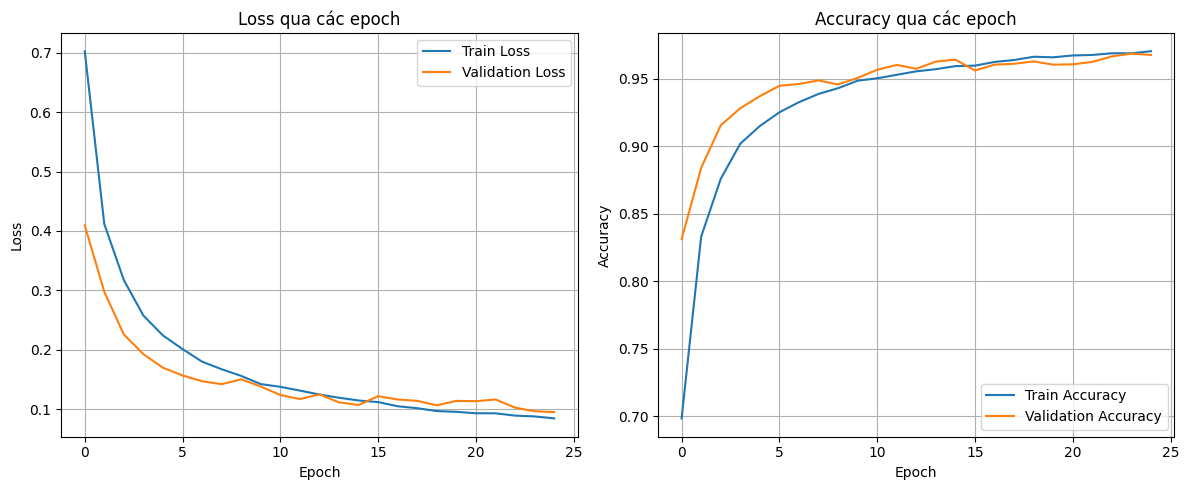

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss qua các epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy qua các epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()